In [1]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import sim_models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns

In [2]:
# # Select the data subsets to use
# # E_min : [0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 2.609, 3.586, 4.332, 5.475]
# # E_max : [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 2.624, 3.598, 4.342, 5.484]
E_min = 0.676
E_max = 2.624
which_data = 'som'

# Select the model
parameterization = 'sim_bs_C'

# Parameters of sampling
n_steps = 10000
n_burn = 5000

# Use theory cov?
use_theory_cov = True

# Set a specific prior? (Default set: None)
param_bounds = None
params_prior = None

# Samples file
file_name = './03_18_2024/run0/samples_0.h5'

# Plot things?
plot_trace = True
plot_prob = False


# Correlation matrix (only ERPs vs. include all ERPs + norm)
just_ERPs = True

# Plot cross sections?
# If true, this takes a long time if they are not precomputed
plot_cs = False
# Cross sections file (If I precompute them)
cross_section_file = None


In [3]:
loader = DataLoader(E_min, E_max, which_data)

data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

In [4]:
if parameterization == 'sim_bs_C':
    labels = ['$\\bar{c}^{2}$', '$\Lambda_{B}$', '$A_{0}$', '$r_{0}$', '$(C_{1}^{+})^{2}$', '$P_{1}^{+}$', '$(C_{1}^{-})^{2}$', '$P_{1}^{-}$']
    if param_bounds is None:
        param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6]])
    if params_prior is None:
        params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = sim_models.Sim_BS_C(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)
else:
    sys.stderr.write('Nothing else is implemented yet...')
    sys.exit(-1)

# Add normalization labels
if labels is not None:
    for i in range(0, int(np.max(norm_group) + 1)):
        labels.append('$f_{}$'.format(i))

In [5]:
# Load in the samples
reader = emcee.backends.HDFBackend(file_name)
samples_not_flat = reader.get_chain()
samples_flat = reader.get_chain(flat = True)

In [6]:
def generate_trace_plot(samples_not_flat, *args, **kwargs):
    # Generate the trace plot given a set of samples
    fig, axes = plt.subplots(samples_not_flat.shape[2], figsize = (20, 40))
    for i in range(0, samples_not_flat.shape[2]):
        ax = axes[i]
        for j in range(0, samples_not_flat.shape[1]):
            ax.plot(samples_not_flat[:, :, i][:, j])
            if labels is not None:
                ax.set_ylabel(labels[i])
    axes[-1].set_xlabel('Step Number')
    plt.show()

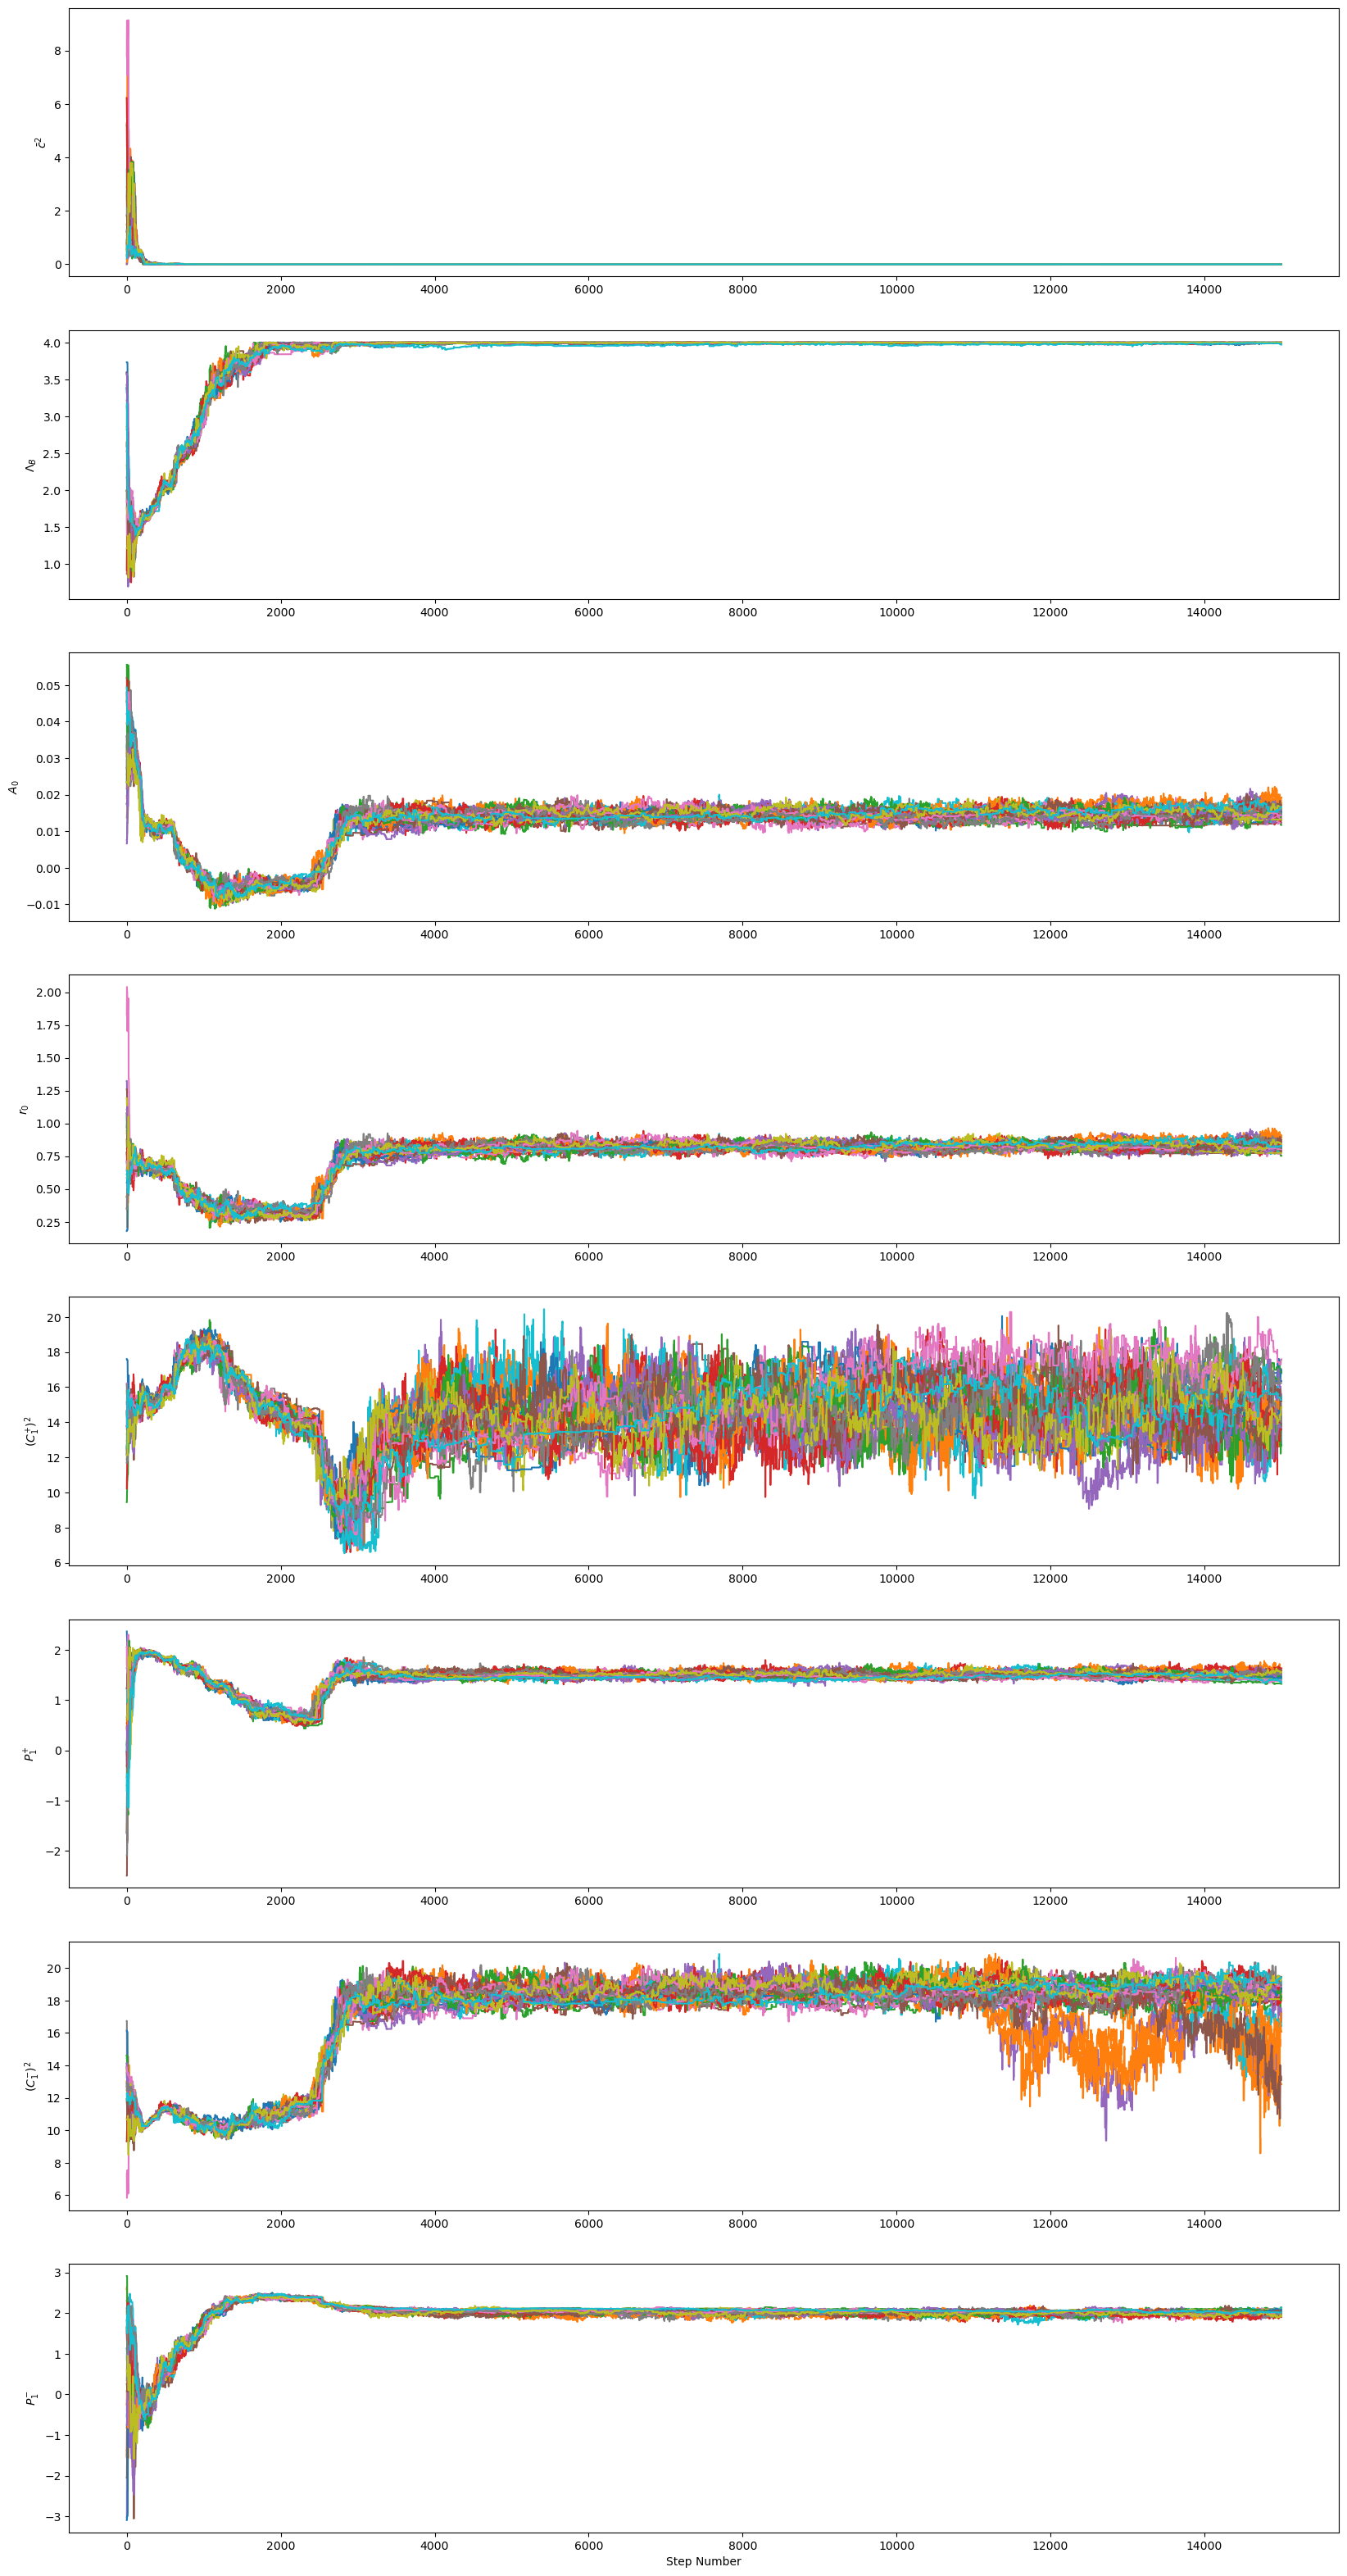

In [8]:
if plot_trace:
    generate_trace_plot(samples_not_flat[:, :, :model.erp_dim + 2])

# if plot_trace:
#     generate_trace_plot(samples_not_flat)

In [9]:
# Look at the variances within each chain to determine if the walker is moving enough or if it is stuck.
within_chain_means = np.mean(samples_not_flat[n_burn:, :, :], axis = 0)

# Create an empty array of the within chain variances
within_chain_var = np.empty(within_chain_means.shape)

# Run a for loop across all walkers to compute the within chain variance
for i in range(0, within_chain_means.shape[0]):
    within_chain_var[i, :] = np.sum(np.square(within_chain_means[i, :] - samples_not_flat[n_burn:, i, :]), axis = 0) / (samples_not_flat.shape[0] // 2)

# Get the typical within chain variance W for each parameter
W = np.median(within_chain_var, axis = 0)


# Now we need to loop over each chain for each parameter to see how it compares to the typical variance
bad_indices = []
ratios = np.empty(within_chain_means.shape)
# Loop over each parameter
for i in range(0, within_chain_means.shape[1]):
    # Loop over the walkers
    for j in range(0, within_chain_means.shape[0]):
        ratio = np.sum(within_chain_var[j, i] / W[i]) / within_chain_means.shape[1]
        ratios[j, i] = ratio

# Sum along each parameter, this value should be very close to 1.0. Select out the bad indices
total_normalized_ratios = np.sum(ratios, axis = 1)
bad_indices = np.where(total_normalized_ratios <= 0.9)[0]
print('Found {} bad walkers at indices:'.format(bad_indices.shape[0]))
print(bad_indices)

if bad_indices.shape[0] != 0:
    # Remove the bad walkers
    samples_not_flat = np.delete(samples_not_flat, bad_indices, axis = 1)

Found 6 bad walkers at indices:
[ 2 10 17 18 26 28]


In [10]:
# if plot_trace:
#     generate_trace_plot(samples_not_flat[n_burn:, :, :2])

In [11]:
# Thin according to the burn-in time
thinned_samples_not_flat = samples_not_flat[n_burn:, :, :]

# Compute the autocorrelation times for each parameter
ac_s = reader.get_autocorr_time(discard = n_burn, tol = 0)
ac = int(np.max(ac_s))

# Thin according to the autocorrelation time
thinned_samples_not_flat = thinned_samples_not_flat[::ac, :, :]

# Flatten the samples and log-prob
len0, len1, len2 = thinned_samples_not_flat.shape
samples = np.reshape(thinned_samples_not_flat, (len0 * len1, len2))

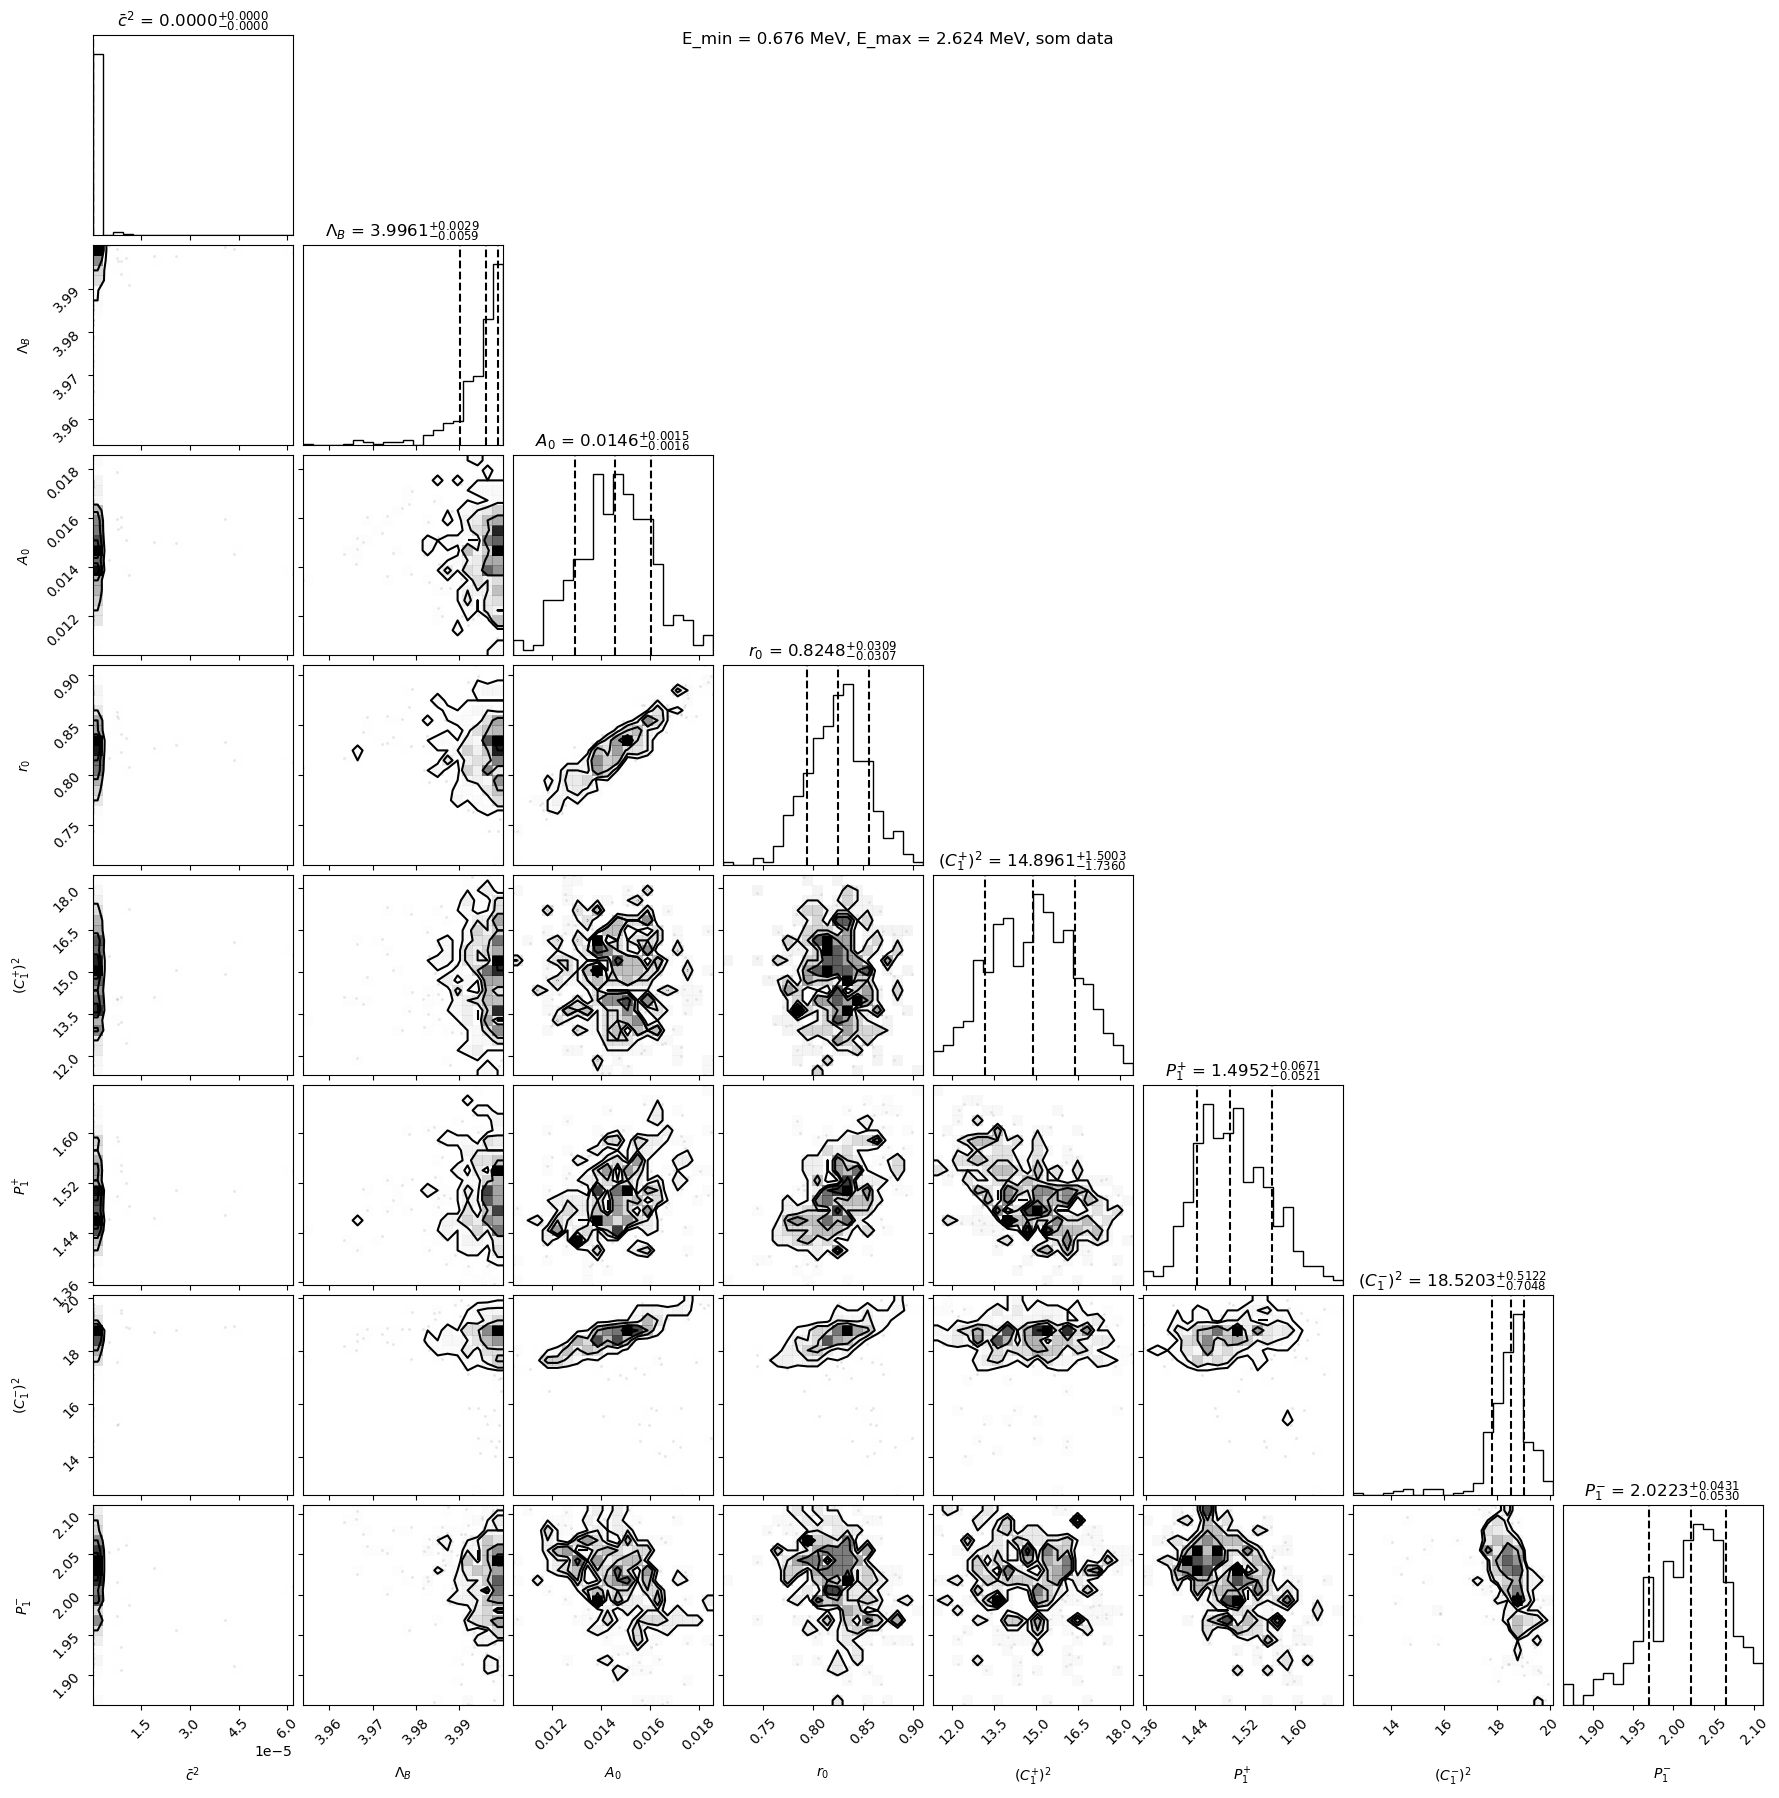

In [12]:
corner.corner(samples[:, :model.erp_dim + 2], labels = labels[:model.erp_dim + 2], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle("E_min = {} MeV, E_max = {} MeV, {} data".format(E_min, E_max, which_data))
plt.show()